In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import scikitplot.plotters as skplt

import nltk

from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

C:\Users\jfeng\AppData\Local\Continuum\miniconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


## Load training_text and training_variants

In [4]:
df_train_txt = pd.read_csv('data/training_text', 
                           encoding='utf-8', keep_default_na=False,
                           sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_train_txt.head()

C:\Users\jfeng\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
df_train_var = pd.read_csv('data/training_variants')
df_train_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [6]:
df_test_txt = pd.read_csv('data/test_text', 
                          encoding='utf-8', keep_default_na=False,
                          sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_test_txt.head()

C:\Users\jfeng\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [8]:
df_test_var = pd.read_csv('data/test_variants')
df_test_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


### Let's join them together

In [9]:
df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [10]:
df_test = pd.merge(df_test_var, df_test_txt, how='left', on='ID')
df_test.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


## Run preliminary statistics on loaded data

In [11]:
df_train.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3321
unique,NaN,264,2996,NaN,1921
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [12]:
df_test.describe(include='all')

,ID,Gene,Variation,Text
count,5668.000000,5668,5668,5668
unique,NaN,1397,5628,5611
top,NaN,F8,Truncating Mutations,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,134,18,6
mean,2833.500000,NaN,NaN,NaN
std,1636.354994,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,1416.750000,NaN,NaN,NaN
50%,2833.500000,NaN,NaN,NaN
75%,4250.250000,NaN,NaN,NaN


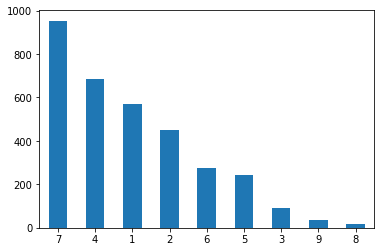

In [13]:
df_train['Class'].value_counts().plot(kind="bar", rot=0)

### Classes seem very imbalanced

In [14]:
# This cell reduces the training data for Kaggle limits. Remove this cell for real results.
df_train, _ = train_test_split(df_train, test_size=0.7, random_state=8, stratify=df_train['Class'])
df_train.shape

(996, 5)

### The main task here is to predict the class of the mutation given the text in the literature. Our approach will then be to apply some common NLP techniques to transform the free text into features for an ML classifier and see which ones work best.

### Define a helper function to evaluate the effectiveness of transformed free text. We'll use a simple logistic regression with 3-fold stratified cross-validation for fast evaluation.

In [15]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)


Let's do a quick test of evaluate_features

C:\Users\jfeng\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Log loss: 0.34456225154048314
Accuracy: 0.9466666666666667


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
C:\Users\jfeng\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


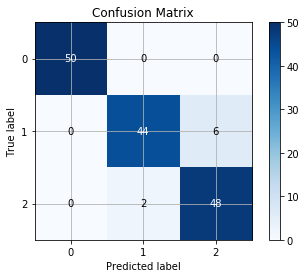

In [16]:
# Quick test of evaluate_features
from sklearn.datasets import load_iris
evaluate_features(*load_iris(True))

## Start with a simple baseline. Bag of words

In [17]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    


In [18]:
bag_of_words = count_vectorizer.fit_transform(df_train['Text'])

In [19]:
len(count_vectorizer.get_feature_names())

157726

#### 281586 unique words in corpus

In [ ]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)

In [ ]:
evaluate_features(truncated_bag_of_words, df_train['Class'].values.ravel())

In [ ]:
evaluate_features(truncated_bag_of_words, df_train['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

### Bad results overall for the baseline

## Let's try TFIDF

In [ ]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(df_train['Text'])

len(count_vectorizer.get_feature_names())

In [ ]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

In [ ]:
evaluate_features(truncated_tfidf, df_train['Class'].values.ravel())

In [ ]:
evaluate_features(truncated_tfidf, df_train['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

In [ ]:
evaluate_features(tfidf, df_train['Class'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

### A little better, but still bad. You can see from the confusion matrix that it's just classifying most samples into class 7.

### Also tried a linear SVM for features straight from TFIDF (did not go through Truncated SVD). Worse log loss but confusion matrix seems to show better balance among predicted classes.

_____

## This time, let's try the popular word2vec to get features

### Define helper function get_word2vec  and helper class MySentences for training word2vec on the corpus of texts. (or loading if already trained and saved to disk)

In [ ]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

### Start training the word2vec model. Since word2vec training is unsupervised, you can use both training and test datasets.

If training has already been done, the function will just load the word2vec to disk so you don't need to retrain if rerunning the notebook

In [ ]:
w2vec = get_word2vec(
    MySentences(
        df_train['Text'].values, 
        #df_test['Text'].values  Commented for Kaggle limits
    ),
    'w2vmodel'
)

### Now that we have our word2vec model, how do we use it to transform each documents into a feature vector? In order to convert a document of multiple words into a single vector using our trained word2vec, we take the word2vec of all words in the document, then take its mean.

### We'll define a transformer (with sklearn interface) to convert a document into its corresponding vector

In [ ]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)


In [ ]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(df_train['Text'])

In [ ]:
evaluate_features(mean_embedded, df_train['Class'].values.ravel())

In [ ]:
evaluate_features(mean_embedded, df_train['Class'].values.ravel(),
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

In [ ]:
evaluate_features(mean_embedded, 
                  df_train['Class'].values.ravel(),
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,
                                )
                 )

### As expected, we get better results than TF-IDF. 

The results are still not very good though. One way to explain this is that there is a lot of information loss from just getting the mean of all word vectors of the document. This is roughly analogous to taking the entire document, summarizing it into one word, and using that word to classify the entire text.

## Let's try a quick and dirty LSTM in Keras to take into account the sequential nature of text

* We won't do any hyperparameter search 
* We'll go with 15 epochs, and save the model with the best validation loss after an epoch
* Max sequence length is cut down to a measly 2000 (longest text has 77000+ words), to shorten training time and prevent GPU OOM

Note: This takes about an hour to run on GPU

In [ ]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_train['Text'].values)

In [ ]:
# Pad the data 
X = tokenizer.texts_to_sequences(df_train['Text'].values)
X = pad_sequences(X, maxlen=2000)

In [ ]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())

In [ ]:
Y = pd.get_dummies(df_train['Class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

In [ ]:
model = load_model('keras_model')

In [ ]:
probas = model.predict(X_test)

In [ ]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)


### The results of the quick LSTM are promising. 

On the first try with no hyperparameter search, 6th epoch, max sequence length cut down to a measly 2000 (longest text has 77000+ words), we get the best log loss so far of around 1.4. You can still see a bit of bias towards class 7 but the confusion matrix looks more balanced than anything we've seen so far.

### Further tuning of the LSTM will likely produce better results.

## So far, we've only used the text field to perform classification. But there is still the "Gene" and "Variation" fields.

Using only the Text field is a bit flawed. Looking closer at the statistics we calculated above, "training_text" actually has duplicates, and the duplicates have different classes. This is part of the challenge. A lot of papers are studies of 2 or more genes. It is our job to use the other fields to figure out which parts of the text are relevant for the particular Gene and Variation.

### Let's use a LabelEncoder to encode Gene and Variation and combine it with TFIDF

In [ ]:
gene_le = LabelEncoder()
gene_encoded = gene_le.fit_transform(df_train['Gene'].values.ravel()).reshape(-1, 1)
gene_encoded = gene_encoded / np.max(gene_encoded)

In [ ]:
variation_le = LabelEncoder()
variation_encoded = variation_le.fit_transform(df_train['Variation'].values.ravel()).reshape(-1, 1)
variation_encoded = variation_encoded / np.max(variation_encoded)

In [ ]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, truncated_tfidf)), df_train['Class'])

In [ ]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, truncated_tfidf)), df_train['Class'],
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

### Barely any difference, let's try our  label encoded features with our word2vec features

In [ ]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, mean_embedded)), df_train['Class'])

In [ ]:
evaluate_features(np.hstack((gene_encoded, variation_encoded, mean_embedded)), df_train['Class'],
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

### Doesn't make a difference either. Let's try one-hot encoding + SVD the "Gene" and "Variation" features

In [ ]:
one_hot_gene = pd.get_dummies(df_train['Gene'])
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)

In [ ]:
one_hot_variation = pd.get_dummies(df_train['Variation'])
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)

### Truncated one hot encoding + TFIDF

In [ ]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, truncated_tfidf)), df_train['Class'])

In [ ]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, truncated_tfidf)), df_train['Class'],
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))


### Truncated one hot encoding + word2vec

In [ ]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, mean_embedded)), df_train['Class'])

In [ ]:
evaluate_features(np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, mean_embedded)), df_train['Class'],
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

### Interestingly, performance is actually a bit worse than simple label encoding

## Before going into a summary of the insights we've discovered, let's generate some submissions from our best models and see how they fare in the public leaderboard

### We'll start by generating a submission from our word2vec model

In [ ]:
lr_w2vec = LogisticRegression()
lr_w2vec.fit(mean_embedded, df_train['Class'])

In [ ]:
mean_embedded_test = mean_embedding_vectorizer.transform(df_test['Text'])

In [ ]:
probas = lr_w2vec.predict_proba(mean_embedded_test)

In [ ]:
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.head()

In [ ]:
submission_df.to_csv('submission.csv', index=False)

### Test out XGB and SVC

In [ ]:
xgb_w2vec = XGBClassifier(max_depth=4,
                          objective='multi:softprob',
                          learning_rate=0.03333)
xgb_w2vec.fit(mean_embedded, df_train['Class'])
probas = xgb_w2vec.predict_proba(mean_embedded_test)
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.to_csv('submission.csv', index=False)

In [ ]:
svc_w2vec = SVC(kernel='linear', probability=True)
svc_w2vec.fit(mean_embedded, df_train['Class'])
probas = svc_w2vec.predict_proba(mean_embedded_test)
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.to_csv('submission.csv', index=False)

#### Public LB Score Log Reg: 1.032000

#### Public LB Score XGB: 0.96536

#### Public LB Score SVC: 0.97059

### Let's try our Keras model

In [ ]:
Xtest = tokenizer.texts_to_sequences(df_test['Text'].values)
Xtest = pad_sequences(Xtest, maxlen=2000)

In [ ]:
probas = model.predict(Xtest)

In [ ]:
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.head()

In [ ]:
submission_df.to_csv('submission.csv', index=False)

#### Public LB Score: 1.00234

## Summary

The aim of this notebook was to do some quick exploration of the dataset and apply some common ML techniques to the classification task. The metric to maximize is multiclass log loss.

A big part of the problem is to teach an ML model how to "read" medical literature and classify the given Gene and Variation into 1 out of 9 classes.

Thus, the first part of this notebook focused on applying common techniques to preprocess and vectorize free text and evaluate its effectiveness by running them through vanilla Logistic Regression and Random Forest.

The techniques used, from least effective to most effective, were:

* Bag of Words
* TF-IDF
* Word2Vec

Because the above approaches did not take into account the temporal patterns in free text, a quick LSTM was tried as well. This approach scored higher than the above without any tuning.

In the second part of the notebook, I added the "Gene" and "Variation" features next to the free text features. I tried both label encoding and one-hot encoding, however, the results did not show much improvement.

In the third part of the notebook, I generated submissions for both Word2Vec (multiple classifiers) and Keras LSTM and recorded the public leaderboard scores of each submission. The scores were better (around 1) but did not show the same relationships with each other as my own CV (they were mostly close to each other). This is a common occurrence in Kaggle competitions since the public leaderboard is scored on a smaller subset of the test data. Most Kagglers' advice is to ignore the public leaderboard and trust your own CV.

## Further things to try

This notebook's aim was mostly figuring out which techniques are worth exploring and was not intended to generate very competitive submissions. The following is a list of suggestions to try for further improvement.

* There are tons of other techniques for free text other than the ones I listed above. Make sure to explore other techniques such as Doc2Vec, DeepIR, and Word Mover's distance

* Focus more on capturing the relationship between "Gene" and "Variation" with the free text features. Since "Text" is sometimes duplicated (with different classes!), taking into account "Gene" and "Variation" is very important.

* Explore different deep learning architectures for the data. One idea for an architecture is to combine a simple Embedding + LSTM for the free text and concatenate the input with "Gene" and "Variation" Embeddings, leading into a final fully connected layer for the classes. Hopefully, this will capture the relationship between the text and the "Gene" + "Variation" columns.

* Train Word2Vec on a bigger corpus of genetic and medical data. Since Word2Vec is unsupervised, we can get better embeddings with more data, and consequently, better predictions

* Don't forget to do hyperparameter optimization when you're happy with a set of features. Stacked ensembling is also an almost guaranteed way to get a small boost to your score. We skipped this entirely in this notebook as this is usually the last step in the process. Try http://xcessiv.readthedocs.io/.

